# Autonomous Driving - Car Detection - YOLO Algorithm

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import imghdr
import colorsys
import random
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras.models import load_model
from PIL.Image import Resampling
from yad2k.models import keras_yolo
from tensorflow.keras import backend as K

# YOLO Algorithm
- Achieves high accuracy while also being able to run in real time. 
- "Only looks once" at the image
 - requires only one forward propagation pass through the network to make predictions.

# Model

- The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 425). 
- Each bounding box is represented by 6 numbers $(b_x, b_y, b_h, b_w, p_c, c)$
- If expand c into 80 dims vecter, then each bounding box is then represented by 85 numbers. 

## Non-max Suppression 

###  Filtering with a Threshold on Class Scores
-  Class Score: $score_{c,i} = p_{c} \times c_{i}$ where $p_{c}$ is the probability that there is an object and $c_{i}$ is the probability that the object is a certain class.

In [2]:
def yolo_filter_by_scores(boxes, box_confidence, box_class_probs, threshold = .6):
    """
    Return scores containing the class probability score, boxes containing (b_x, b_y, b_h, b_w) coordinates,
    classes containing the index of the class after filtering out the selected boxes from <boxes> with box score 
    (<box_confidence> * <box_class_probs>) lower than the <threshold>
    """
    
    # box_confidence contains the probability that there is an object
    # box_class_probs contains the probability that the object is a certain class
    box_scores = box_confidence * box_class_probs

    # Find the index with largest value across the last dimension which is the prob scores for each class
    box_classes = tf.math.argmax(box_scores, axis=-1)
    # Find the largest value 
    box_class_scores = tf.math.reduce_max(box_scores, axis=-1)

    # Create a filtering mask which keeps the boxes above the threshold
    filtering_mask = box_class_scores >= threshold
    
    # Find the values above the threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

###  Filtering with a Threshold on IoU

In [3]:
def get_iou(box1, box2):
    """
    Return the intersection over union (IoU) between <box1> and <box2>
    """

    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the area of intersection between box1 and box2
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = max(xi2 - xi1, 0)
    inter_height =  max(yi2 - yi1, 0)
    inter_area = max(inter_width * inter_height, 0)
    
    # Calculate the area of union between box1 and box2
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # Calculate the IoU
    iou = inter_area / union_area
    
    return iou

In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Return the predicted score, predicted box coordinates, and predicted class for each box, after applying 
    non-max suppression (NMS) on boxes coordinates <boxes>, class probability score <scores>, max number
    of boxes <max_boxes> and <iou_threshold> and <classes> containing the index of the class 
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32') 

    # Get the list of indices corresponding to the boxes we need
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=0.5, name=None)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    return scores, boxes, classes

### Get The Output of The YOLO Encoding after NMS Filtering

- There are a few ways of representing boxes, such as via their corners or via their midpoint and height/width.
- Convert the boxes coordinates to corners' coordinates for convenience

In [5]:
def boxes_to_corners(box_xy, box_wh):
    """
    Converts the yolo box coordinates (x,y,w,h), <box_xy>, <box_wh> to box corners' coordinates (x1, y1, x2, y2)
    """
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

- YOLO's network was trained to run on 608x608 images <br>
- The car detection dataset had 720x1280 images
- Rescale the boxes so that they can be plotted on top of the original 720x1280 image.

In [6]:
def scale_boxes(boxes, image_shape):
    """ 
    Return the scaled boxes so the predicted boxes <boxes> can be drawable on the image of shape <image_shape>
    """
    
    height = float(image_shape[0])
    width = float(image_shape[1])
    image_dims = tf.keras.backend.stack([height, width, height, width])
    image_dims = tf.keras.backend.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    
    return boxes

In [7]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Return the predicted score, predicted box coordinates, and predicted class for each box by converting 
    the output of YOLO encoding <yolo_outputs>
    """
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = boxes_to_corners(box_xy, box_wh)
    
    # Box score filtering
    scores, boxes, classes = yolo_filter_by_scores(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes to be plotted on image_shape image
    boxes = scale_boxes(boxes, image_shape)
    
    # Non-max suppression
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
  
    return scores, boxes, classes

# Test YOLO Pre-trained Model

In [8]:
# Load the names of the 80 different classes and the coordinates of the 5 anchor boxes

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        # last dimension of anchors contains width and height
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [9]:
class_names = read_classes("model_data/coco_classes.txt") #shape(80, )
anchors = read_anchors("model_data/yolo_anchors.txt") # shape(5, 2)
model_image_size = (608, 608)

### Load a Pre-Trained YOLO Model

In [12]:
yolo_model = load_model("model_data/", compile=False)

Metal device set to: Apple M1


2022-08-25 17:33:28.413167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-25 17:33:28.413358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

                                                                                                  
 batch_normalization_8 (BatchNo  (None, 38, 38, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 38, 38, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 38, 38, 256)  131072      ['leaky_re_lu_8[0][0]']          
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 38, 38, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
          

 conv2d_20 (Conv2D)             (None, 38, 38, 64)   32768       ['leaky_re_lu_12[0][0]']         
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 19, 19, 1024  0           ['batch_normalization_18[0][0]'] 
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 38, 38, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_19 (Conv2D)             (None, 19, 19, 1024  9437184     ['leaky_re_lu_18[0][0]']         
                                )                                                                 
          

### Pre-process Input

- Pre-processed the images into 608x608 images so they can be run through the YOLO Model

In [14]:
def preprocess_image(img_path, model_image_size):
    image = Image.open(img_path)
    # model_image_size = (608, 608)
    resized_image = image.resize(tuple(reversed(model_image_size)), Resampling.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    # Normalization
    image_data /= 255.
    # Expand the shape of an array
    image_data = np.expand_dims(image_data, axis=0)  
    return image, image_data

### Convert YOLO Output to Usable Bounding Box Tensors

<img src="nb_images/yolo model process.png" style="width:950px;height:250;">



<img src="nb_images/YOLO prediction visualization.jpg" style="width:350px;height:100;">

- $t_x$ and $t_y$ relate to the predicted center of the bounding box
- $c_x$ and $c_y$ are integers between 0 and the number of grid cells
- $t_w$ and $t_h$ relate to the predicted size (shape) of the bounding box
- $p_w$ and $p_h$ are anchor box shape

In [15]:
def yolo_head(model_output, anchors, num_classes):
    """
    Return the box positions, confidence, probability for all candidate boxes, using the final layer features of 
    the yolo model <model_output>, dimensions of the anchor boxes <anchors> and number of classes <num_classes>.
    """
    
    num_anchors = len(anchors) # 5
    
    # Reshape to batch, height, width, num_anchors, box_params. 
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # model_output has shape (m, 19, 19, 425)
    conv_dims = K.shape(model_output)[1:3]  
    
    # K.arange(start, stop): creates a 1D tensor containing a sequence of integers
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    
    # K.tile(x, n): create a tensor by tiling x by n (repeat x n times), len(n) = dimension of x
    # shape (361, )
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])
    
    # Expand width to two dimensions (1, 19), and tile it to (19, 19) 
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    
    # Shape (361, )
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    
    # Stack result in an array of shape (2, 361) and then transpose to (361, 2)
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    
    # K.cast: Casts a tensor to a different dtype and returns it.
    conv_index = K.cast(conv_index, K.dtype(model_output))

    # reshape output to (m, 19, 19, 5, 85)
    model_output = K.reshape(model_output, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(model_output))
    
    # model_output[..., :2] contains t_x, t_y
    box_xy = K.sigmoid(model_output[..., :2])
    # model_output[..., 2:4] contains t_w, t_h
    box_wh = K.exp(model_output[..., 2:4])
    # model_output[..., 4:5] contains p_c: probability for whether there is a object  
    box_confidence = K.sigmoid(model_output[..., 4:5])
    # model_output[..., 5:] are the probablities for the 80 classes
    box_class_probs = K.softmax(model_output[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

### Helper Functions for Visualization

In [16]:
def get_colors_for_classes(num_classes):
    """
    Return list of random colors for number of classes <num_classes> given.
    """
    # Use previously generated colors if num_classes is the same.
    # The hasattr() function returns True if the specified object has the specified attribute.
    if (hasattr(get_colors_for_classes, "colors") and
            len(get_colors_for_classes.colors) == num_classes):
        return get_colors_for_classes.colors

    hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    get_colors_for_classes.colors = colors  # Save colors for future calls.
    return colors

In [17]:
def draw_boxes(image, boxes, box_classes, class_names, scores=None):
    """
    Draw bounding boxes <boxes> with class name <class_names> and optional box score <scores> on image <image>.
    """
    
    font = ImageFont.truetype(
        font='font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        draw = ImageDraw.Draw(image)
        
        # draw.textbbox: returns bounding box (in pixels) of given text relative to given anchor
        label_size = draw.textbbox((0,0), label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[3] >= 0:
            text_origin = np.array([left, top - label_size[3]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size[2:])],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return np.array(image)

## Get Prediction

In [18]:
def predict(image_file):
    """
    Return the predicted score, predicted box coordinates, and predicted class for each box, and print and plot 
    predictions for the image <image_file>
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("predictions", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("predictions", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/test.jpg
car 0.89 (367, 300) (745, 648)
car 0.80 (761, 282) (942, 412)
car 0.74 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 705)
bus 0.67 (5, 266) (220, 407)
car 0.66 (706, 279) (786, 350)
car 0.60 (925, 285) (1045, 374)
car 0.44 (336, 296) (378, 335)
car 0.37 (965, 273) (1022, 292)
traffic light 0.36 (681, 195) (692, 214)


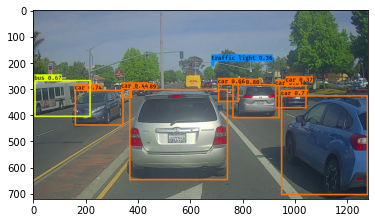

In [20]:
out_scores, out_boxes, out_classes = predict("test.jpg")

Found 10 boxes for images/Traffic.jpeg
car 0.86 (1183, 407) (1477, 601)
car 0.79 (402, 429) (684, 696)
car 0.73 (419, 88) (550, 181)
car 0.67 (534, 128) (684, 236)
car 0.65 (1531, 251) (1790, 458)
person 0.63 (753, 891) (889, 966)
car 0.63 (555, 99) (695, 205)
car 0.60 (185, 104) (352, 253)
person 0.47 (782, 73) (815, 133)
car 0.44 (510, 807) (959, 1078)


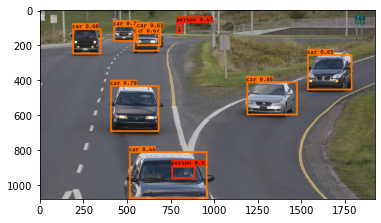

In [21]:
out_scores, out_boxes, out_classes = predict("Traffic.jpeg")

Found 9 boxes for images/0005.jpg
car 0.75 (517, 282) (689, 336)
car 0.72 (883, 260) (1026, 303)
car 0.67 (15, 313) (128, 362)
car 0.65 (741, 266) (918, 313)
car 0.64 (207, 297) (338, 340)
car 0.49 (1256, 253) (1280, 310)
traffic light 0.40 (412, 182) (426, 209)
fire hydrant 0.35 (1055, 411) (1132, 526)
traffic light 0.33 (0, 97) (20, 154)


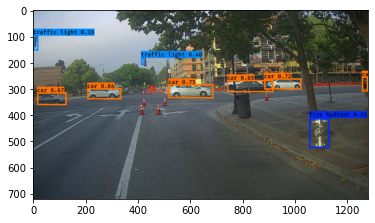

In [24]:
out_scores, out_boxes, out_classes = predict("0005.jpg")